In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [11]:
dataframe = pd.read_csv('californiabin.csv', header=None)
dataframe

,0,1,2,3,4,5,6,7,8
0,4.1685,20.0,6.700637,1.178344,745.0,2.372611,38.80,-121.15,1.0
1,2.8194,24.0,4.762500,1.020833,608.0,2.533333,36.75,-119.85,0.0
2,2.4250,46.0,4.927711,1.018072,772.0,2.325301,36.33,-119.31,0.0
3,3.1205,16.0,3.728477,1.101545,1260.0,2.781457,33.87,-117.99,0.0
4,4.3889,41.0,5.741007,1.199041,837.0,2.007194,34.15,-118.40,1.0
...,...,...,...,...,...,...,...,...,...
1995,0.9220,15.0,6.287671,1.301370,160.0,2.191781,33.36,-115.91,0.0
1996,3.4464,33.0,4.968085,1.060284,915.0,3.244681,37.45,-121.06,0.0
1997,6.8787,38.0,6.125203,0.980488,1455.0,2.365854,37.52,-122.29,1.0
1998,7.9761,52.0,7.709756,1.151220,842.0,2.053659,37.80,-122.44,1.0


In [12]:
attributes, targets = dataframe.iloc[:, :-1].values, dataframe.iloc[:, -1].values

## SVM

In [13]:
parameters = {
    'svc__C' : [2**i for i in range(-5, 16)],
    'svc__gamma' : [2**i for i in range(-15, 4)]
}

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from joblib import dump

scaler = StandardScaler()
model = SVC(probability=True)

metrics = np.zeros((1, 4))

models = [None for i in range(3)]

train_attributes, test_attributes, train_targets, test_targets = train_test_split(attributes, targets, test_size=0.2, shuffle=True, random_state=0)

pipe = Pipeline(steps=[('scaler', scaler), ('svc', model)])

cv = GridSearchCV(estimator=pipe, param_grid=parameters, cv=10, n_jobs=-1)

cv.fit(train_attributes, train_targets)

model = cv.best_estimator_
models[2] = cv.best_params_

normal_train_attributes = scaler.fit_transform(train_attributes)
normal_test_attributes = scaler.transform(test_attributes)

model.fit(normal_train_attributes, train_targets)

prediction = model.predict(normal_test_attributes)
prediction_proba = model.predict_proba(normal_test_attributes)

acc = accuracy_score(test_targets, prediction)
cm = confusion_matrix(test_targets, prediction, normalize='true')
prec = precision_score(test_targets, prediction)
rec = recall_score(test_targets, prediction)
f1 = f1_score(test_targets, prediction)

metrics = np.array([acc, prec, rec, f1]).astype(float)
models[0] = cm
models[1] = roc_curve(test_targets, prediction_proba[:, 1])
dump(metrics, f'./saved_results/svm/metrics.joblib')
dump(models, f'./saved_results/svm/models.joblib')


ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(probability=True))]). Valid parameters are: ['memory', 'steps', 'verbose'].

/tmp/ipykernel_255/977077267.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


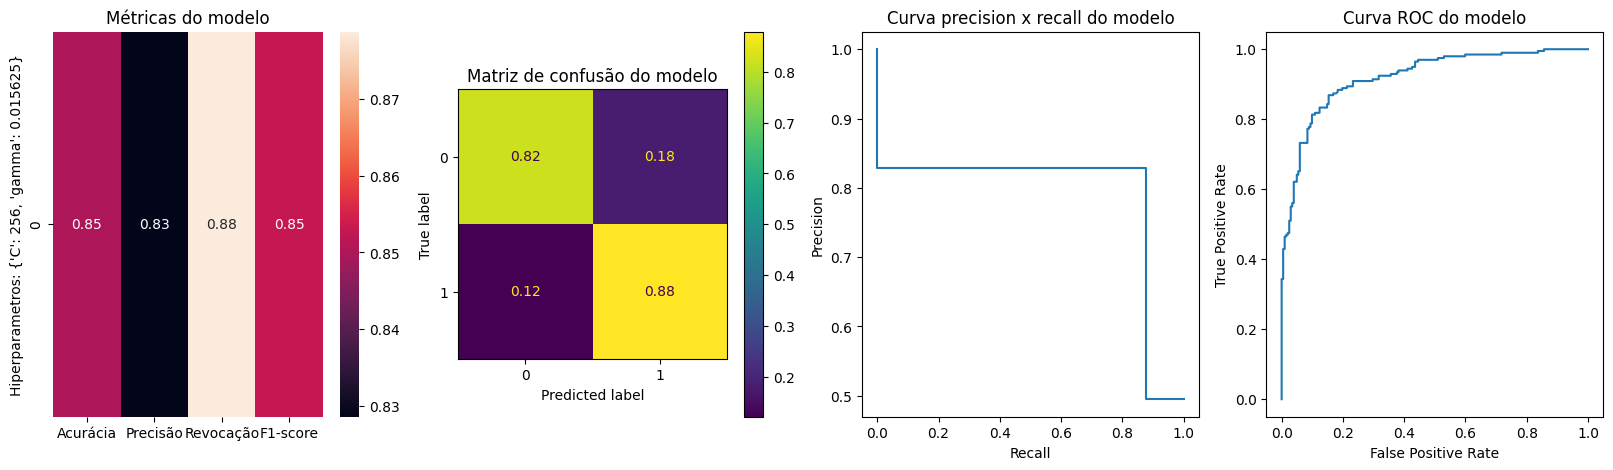

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cmdisplay = ConfusionMatrixDisplay(models[0])
prdisplay = PrecisionRecallDisplay.from_estimator(model, normal_test_attributes, test_targets, ax=ax[2])
rocdisplay = RocCurveDisplay(fpr=models[1][0], tpr=models[1][1])

xlabels = ['Acurácia', 'Precisão', 'Revocação', 'F1-score']
sns.heatmap([metrics], annot=True, xticklabels=xlabels, ax=ax[0])
cmdisplay.plot(ax=ax[1])
rocdisplay.plot(ax=ax[3])

ax[0].set_title('Métricas do modelo')
ax[1].set_title('Matriz de confusão do modelo')
ax[2].set_title('Curva precision x recall do modelo')
ax[3].set_title('Curva ROC do modelo')
ax[0].set_ylabel(f'Hiperparametros: {models[2]}')

fig.show()

## Random Forest

In [ ]:
parameters = {
    'n_estimators' : [i for i in range(10, 210, 10)],
    'max_depth' : [4, 6, 8, 10, None]
}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from tqdm import tqdm
from joblib import dump

metrics = np.zeros((1, 6))

models = [None for i in range(3)]

train_attributes, test_attributes, train_targets, test_targets = train_test_split(attributes, targets, test_size=0.2, shuffle=True, random_state=0)

train_targets = train_targets.astype(float)
test_targets = test_targets.astype(float)

model = RandomForestClassifier()
cv = GridSearchCV(estimator=model, param_grid=parameters, cv=10, n_jobs=-1)

cv.fit(train_attributes, train_targets)

model = cv.best_estimator_
models[2] = cv.best_params_
model.fit(train_attributes, train_targets)

prediction = model.predict(test_attributes)
prediction_proba = model.predict_proba(test_attributes)

acc = accuracy_score(test_targets, prediction)
cm = confusion_matrix(test_targets, prediction, normalize='true')
prec = precision_score(test_targets, prediction)
rec = recall_score(test_targets, prediction)
f1 = f1_score(test_targets, prediction)

metrics = np.array([acc, cm[0][0], cm[1][1], prec, rec, f1]).astype(float)
models[0] = cm
models[1] = roc_curve(test_targets, prediction_proba[:, 1])
dump(metrics, f'./saved_results/random_forest/metrics.joblib')
dump(models, f'./saved_results/random_forest/models.joblib')


['./saved_results/random_forest/models.joblib']

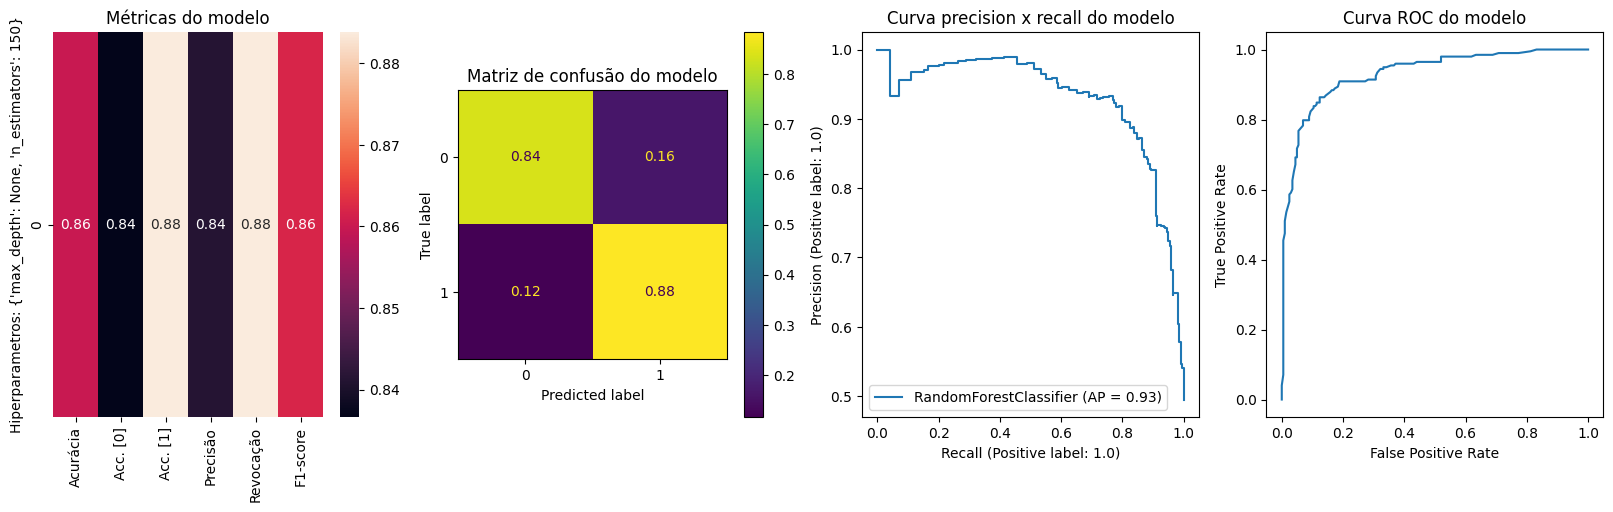

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, auc

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cmdisplay = ConfusionMatrixDisplay(models[0])
prdisplay = PrecisionRecallDisplay.from_estimator(model, test_attributes, test_targets, ax=ax[2])
rocdisplay = RocCurveDisplay(fpr=models[1][0], tpr=models[1][1])

xlabels = ['Acurácia', 'Acc. [0]', 'Acc. [1]', 'Precisão', 'Revocação', 'F1-score']
sns.heatmap([metrics], annot=True, xticklabels=xlabels, ax=ax[0])
cmdisplay.plot(ax=ax[1])
rocdisplay.plot(ax=ax[3])

ax[0].set_title('Métricas do modelo')
ax[1].set_title('Matriz de confusão do modelo')
ax[2].set_title('Curva precision x recall do modelo')
ax[3].set_title('Curva ROC do modelo')
ax[0].set_ylabel(f'Hiperparametros: {models[2]}')

fig.show()